## Question 3
(35%) Neural Networks and Gaussian process. 

Predict the SP500 with the financial indicators assigned to your team in the google spreadsheet (ep, dp, de, dy, dfy, bm, svar,
ntis, infl, tbl , see RLab3 2 GWcausalSP500.R), some lagged series of these indicators and lags of the target using a Neural Network and a GP regression with your desired kernel.

Predict return, or price, or direction (up or down). For which target works best? Do some feature selection to disregard some variables, select appropriate lags: causality, (distance) correlation, VAR-test, Lasso ... (The script RLab5 GausProc.R can be of help. The dataset is goyal-welch2022Monthly.csv and work within the period 1927/2021.)

In [2]:
# bm, ep, ntis

In [102]:
# Packages
import os
import pandas as pd
import numpy as np
import random 
from utils import set_seed, regression_metrics, compute_reg_metrics, compute_class_metrics, classification_metrics
from utils import lag_features

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Models
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import statsmodels.api as sm

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_DIR = 'data'

# Frequency of sampling
tau = 1 #data is monthly. Try tau=12 (year), tau=3 (quarterly)

In [5]:
file = 'goyal-welch2022Monthly.csv'
df = pd.read_csv(os.path.join(DATA_DIR, file)) #,
                   #usecols=['yyyymm', 'Index', 'b/m', 'ep', 'ntis'])

df['Index'] = df['Index'].apply(lambda x: x.replace(',', '')).astype(float)
df['date'] = pd.to_datetime(df['yyyymm'], format='%Y%m')

dateI = "1927-01-01"
dateF = "2021-12-31"
df = df.query(f'date >= "{dateI}" & date <= "{dateF}"')

df['return'] = np.log(df['Index']).diff(tau)

In [6]:
df.columns

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'date', 'return'],
      dtype='object')

In [7]:
### Compute dp, de, ep, dy, dfy
# dividend-price ratio (dp)
df['dp'] = np.log(df['D12']) - np.log(df['Index'])
# dividend-payout ratio (de)
df['de'] = np.log(df['D12']) - np.log(df['E12'])
# earnings to price
df['ep'] = np.log(df['E12']) - np.log(df['Index'])
## dividend yield (remove 1st since lag puts NA in 1st entry)
df['dy'] = np.log(df['D12'].shift(-1)) - np.log(df['Index'].shift(-1))
# Default yield spread (dfy)= BAA-AAA rated corporate bond yields:
df['dfy'] = df['BAA'] - df['AAA']  # Assuming 'BAA' and 'AAA' columns are available

df['date'] = pd.to_datetime(df['date']) 
fig = px.line(df, x='date', y='Index', title='Line Plot of Index Over Time')
fig.show()

df['date'] = pd.to_datetime(df['date'])
fig = px.histogram(df, x='Index', nbins=50, title='Histogram of Index')
fig.show()

In [8]:
# Option 2. Target as Return

fig_hist = px.histogram(df, x='return', nbins=50)
fig_hist.update_layout(
    title='Histogram of Returns',
    xaxis_title='Return',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig_hist.show()

fig_line = px.line(df, x='date', y='return', title='Returns over', labels={'return': 'Return'})
fig_line.show()


In [9]:
# Option 3. Direction (up or down).
df['direction'] = df['Index'].diff(tau) > 0

df['year'] = (df['yyyymm'] / 100).astype(int)

print(df['direction'].value_counts())

#plt.scatter(df['date'], df['direction'].astype(int), alpha=0.5)
#plt.show()

yearly_direction = df.groupby('year')['direction'].mean().reset_index()

# Create a line plot using plotly.express
fig_line = px.line(yearly_direction, x='year', y='direction', 
                   title='Yearly Mean Direction of Index', labels={'direction': 'Average Direction'})
fig_line.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Direction',
    yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Down', 'Up']),  # Adjust as needed
    width=1000,
    height=600
)
fig_line.show()

direction
True     678
False    462
Name: count, dtype: int64


In [10]:
# Select TARGET
type_target = 'return'
if type_target == 'price':
    TARGET = 'Index'
elif type_target == 'return':
    TARGET = 'return'
else:
    TARGET = 'direction'

In [11]:
df.columns

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'date', 'return', 'dp', 'de', 'ep', 'dy', 'dfy',
       'direction', 'year'],
      dtype='object')

['b/m', 'ep', 'ntis']
b/m Null Values - 0
ep Null Values - 0
ntis Null Values - 0


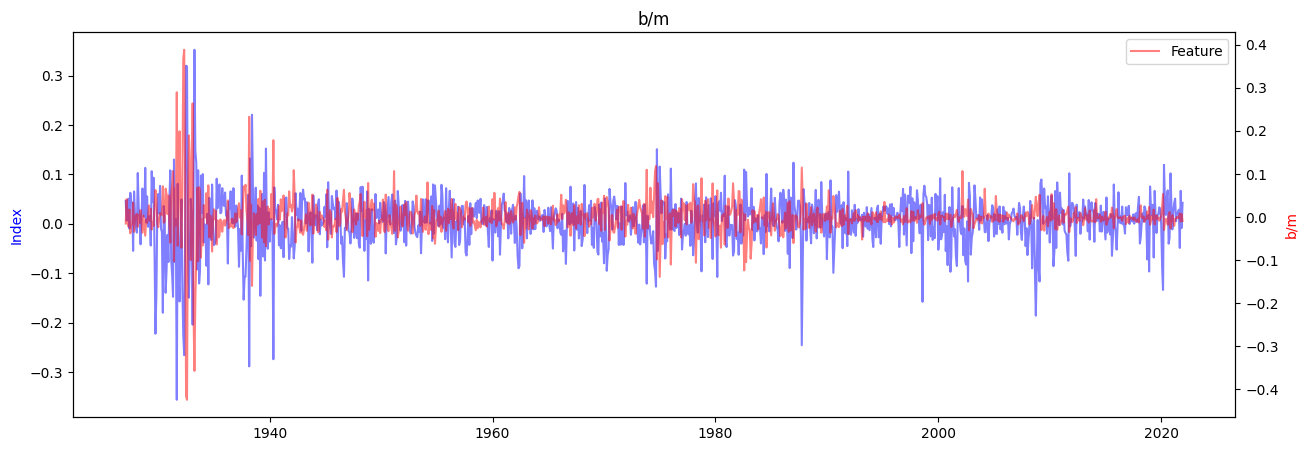

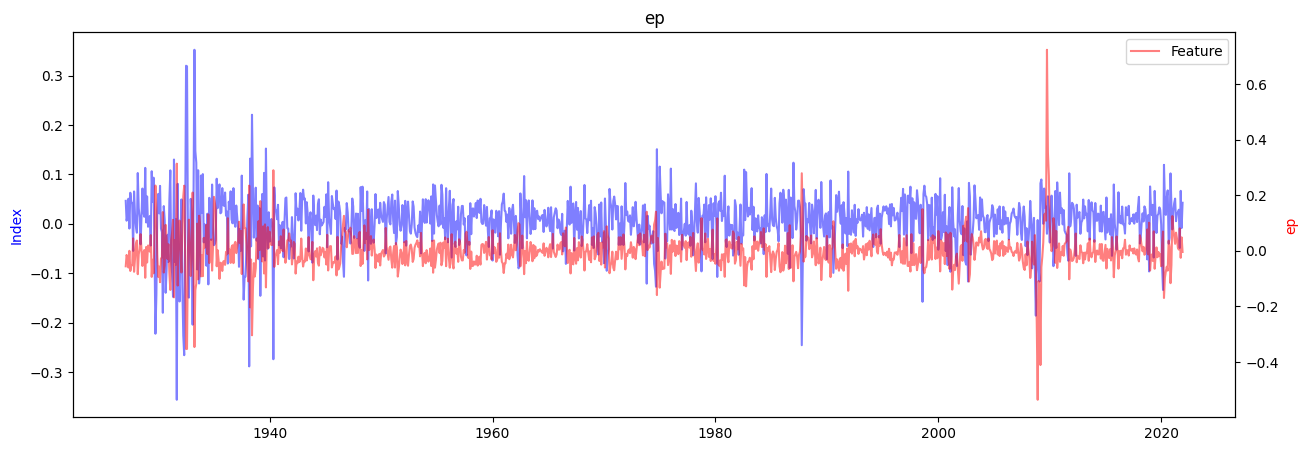

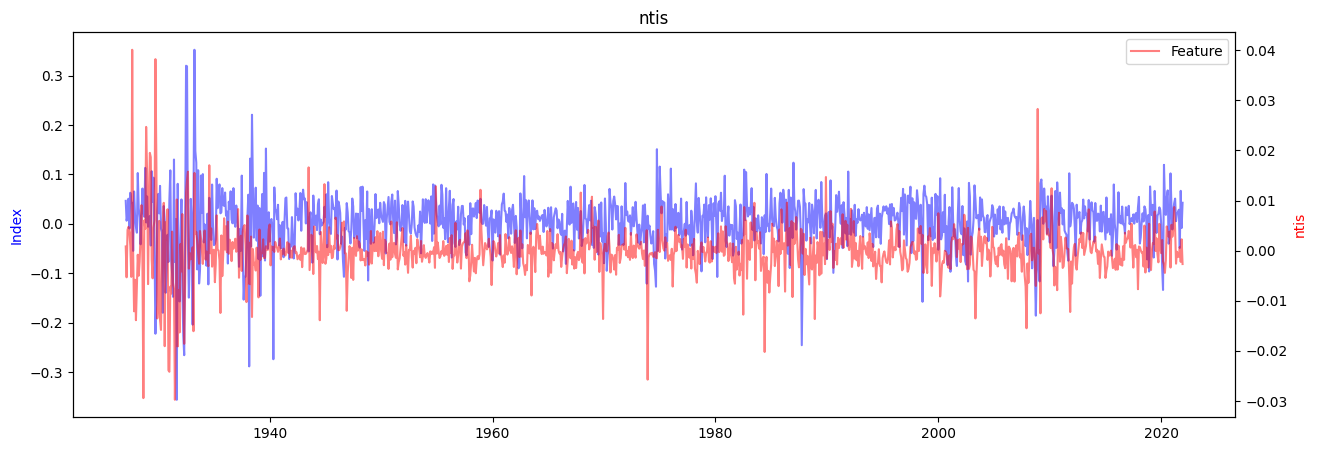

In [12]:
features = list(set(df.columns).intersection(['b/m', 'ntis', 'ep']))#, 'E12', 'D12']))
print(features)

## Checking Null Values
for f in features:
    print(f"{f} Null Values - {df.shape[0] - np.sum(df[f].notnull())}")

for feature in features:
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    ax1.plot(df['date'], df[TARGET], label='Index', color='blue', alpha=0.5)
    ax1.set_ylabel('Index', color='blue')
    
    ax2 = ax1.twinx()
    if TARGET == 'return':
        ax2.plot(df['date'], df[feature].diff(tau), label='Feature', color='red', alpha=0.5)
    else:
        ax2.plot(df['date'], df[feature], label='Feature', color='red', alpha=0.5)

    ax2.set_ylabel(feature, color='red')

    plt.title(f'{feature}')
    plt.legend()
    plt.show()

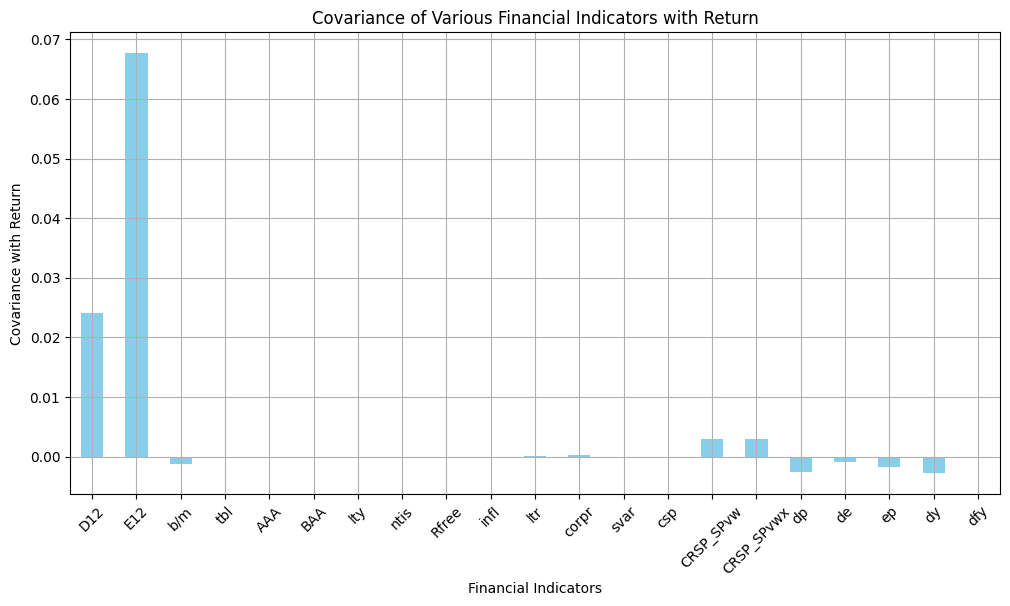

In [13]:
selected_columns = ['D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
                    'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 
                    'CRSP_SPvw', 'CRSP_SPvwx', 'dp', 'de', 'ep', 
                    'dy', 'dfy', 'return']

cov_matrix = df[selected_columns].cov()

return_covariance = cov_matrix.loc['return'].drop('return')  # Drop self covariance

plt.figure(figsize=(12, 6))
return_covariance.plot(kind='bar', color='skyblue')
plt.title('Covariance of Various Financial Indicators with Return')
plt.xlabel('Financial Indicators')
plt.ylabel('Covariance with Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
# Model Inputs:
# Define matrix of features (each column is a feature)
# Features: lags 1,2,3 with (or w/o) PE10 and lags 1,2

lags = 5 #Set lags

data = df.set_index('date')[features+[TARGET]]
print(features)

data = lag_features(data, features = features + [TARGET], lags=5)
    

data = data.dropna()
data = data.drop(features, axis = 1)

new_features = list(set(data.columns).difference([TARGET]))

print(new_features)
data.head()

['b/m', 'ep', 'ntis']
['ep_lag1', 'ep_lag2', 'ep_lag5', 'ntis_lag5', 'ntis_lag4', 'return_lag5', 'b/m_lag4', 'b/m_lag3', 'return_lag2', 'ntis_lag3', 'ntis_lag1', 'b/m_lag1', 'return_lag4', 'return_lag1', 'return_lag3', 'ep_lag4', 'ntis_lag2', 'b/m_lag2', 'ep_lag3', 'b/m_lag5']


,return,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,return_lag1,return_lag2,return_lag3,return_lag4,return_lag5
date,,,,,,,,,,,,,,,,,,,,,
1927-07-01,0.062972,0.452385,0.434783,0.456754,0.469765,0.428501,-2.531330,-2.531446,-2.471309,-2.445079,...,0.058822,0.055275,0.050514,0.046357,0.051668,-0.009434,0.050905,0.017082,0.006482,0.046589
1927-08-01,0.043539,0.414553,0.452385,0.434783,0.456754,0.469765,-2.603707,-2.531330,-2.531446,-2.471309,...,0.059750,0.058822,0.055275,0.050514,0.046357,0.062972,-0.009434,0.050905,0.017082,0.006482
1927-09-01,0.042306,0.396227,0.414553,0.452385,0.434783,0.456754,-2.656742,-2.603707,-2.531330,-2.531446,...,0.054522,0.059750,0.058822,0.055275,0.050514,0.043539,0.062972,-0.009434,0.050905,0.017082
1927-10-01,-0.054554,0.380586,0.396227,0.414553,0.452385,0.434783,-2.707759,-2.656742,-2.603707,-2.531330,...,0.094613,0.054522,0.059750,0.058822,0.055275,0.042306,0.043539,0.062972,-0.009434,0.050905
1927-11-01,0.065578,0.413801,0.380586,0.396227,0.414553,0.452385,-2.662875,-2.707759,-2.656742,-2.603707,...,0.094367,0.094613,0.054522,0.059750,0.058822,-0.054554,0.042306,0.043539,0.062972,-0.009434


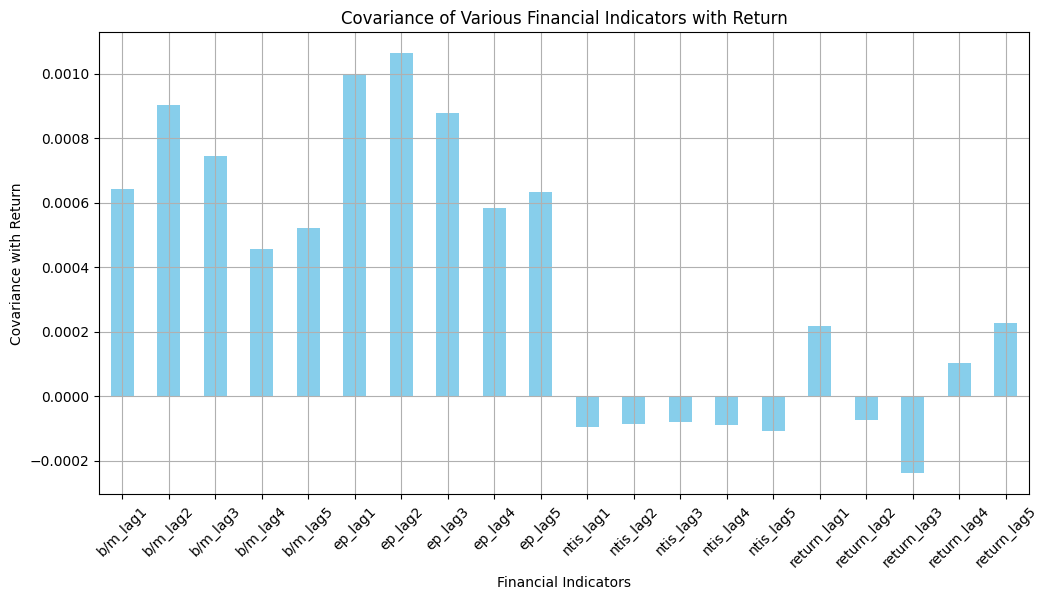

In [15]:
cov_matrix = data.cov()

return_covariance = cov_matrix.loc['return'].drop('return')  # Drop self covariance

plt.figure(figsize=(12, 6))
return_covariance.plot(kind='bar', color='skyblue')
plt.title('Covariance of Various Financial Indicators with Return')
plt.xlabel('Financial Indicators')
plt.ylabel('Covariance with Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [16]:
# Time Series Train test split
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

,return,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,return_lag1,return_lag2,return_lag3,return_lag4,return_lag5
date,,,,,,,,,,,,,,,,,,,,,
1997-12-01,0.015609,0.180746,0.190001,0.177968,0.185505,0.171965,-3.172583,-3.121331,-3.148842,-3.097791,...,0.015667,0.016263,0.014634,0.012877,0.011593,0.043621,-0.035086,0.051789,-0.059162,0.075222
1998-01-01,0.010099,0.178801,0.180746,0.190001,0.177968,0.185505,-3.195884,-3.172583,-3.121331,-3.148842,...,0.015559,0.015667,0.016263,0.014634,0.012877,0.015609,0.043621,-0.035086,0.051789,-0.059162
1998-02-01,0.068078,0.178840,0.178801,0.180746,0.190001,0.177968,-3.207495,-3.195884,-3.172583,-3.121331,...,0.013740,0.015559,0.015667,0.016263,0.014634,0.010099,0.015609,0.043621,-0.035086,0.051789
1998-03-01,0.048738,0.165463,0.178840,0.178801,0.180746,0.190001,-3.277088,-3.207495,-3.195884,-3.172583,...,0.012056,0.013740,0.015559,0.015667,0.016263,0.068078,0.010099,0.015609,0.043621,-0.035086
1998-04-01,0.009036,0.181140,0.165463,0.178840,0.178801,0.180746,-3.327342,-3.277088,-3.207495,-3.195884,...,0.016489,0.012056,0.013740,0.015559,0.015667,0.048738,0.068078,0.010099,0.015609,0.043621


,return,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,return_lag1,return_lag2,return_lag3,return_lag4,return_lag5
date,,,,,,,,,,,,,,,,,,,,,
1998-05-01,-0.019006,0.175873,0.181140,0.165463,0.178840,0.178801,-3.341195,-3.327342,-3.277088,-3.207495,...,0.016405,0.016489,0.012056,0.013740,0.015559,0.009036,0.048738,0.068078,0.010099,0.015609
1998-06-01,0.038680,0.179102,0.175873,0.181140,0.165463,0.178840,-3.327029,-3.341195,-3.327342,-3.277088,...,0.019075,0.016405,0.016489,0.012056,0.013740,-0.019006,0.009036,0.048738,0.068078,0.010099
1998-07-01,-0.011683,0.178061,0.179102,0.175873,0.181140,0.165463,-3.370573,-3.327029,-3.341195,-3.327342,...,0.024011,0.019075,0.016405,0.016489,0.012056,0.038680,-0.019006,0.009036,0.048738,0.068078
1998-08-01,-0.157586,0.179438,0.178061,0.179102,0.175873,0.181140,-3.366445,-3.370573,-3.327029,-3.341195,...,0.025354,0.024011,0.019075,0.016405,0.016489,-0.011683,0.038680,-0.019006,0.009036,0.048738
1998-09-01,0.060526,0.211432,0.179438,0.178061,0.179102,0.175873,-3.216473,-3.366445,-3.370573,-3.327029,...,0.028519,0.025354,0.024011,0.019075,0.016405,-0.157586,-0.011683,0.038680,-0.019006,0.009036


### Model Selection with LASSO

In [17]:
scaler = StandardScaler()
columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)

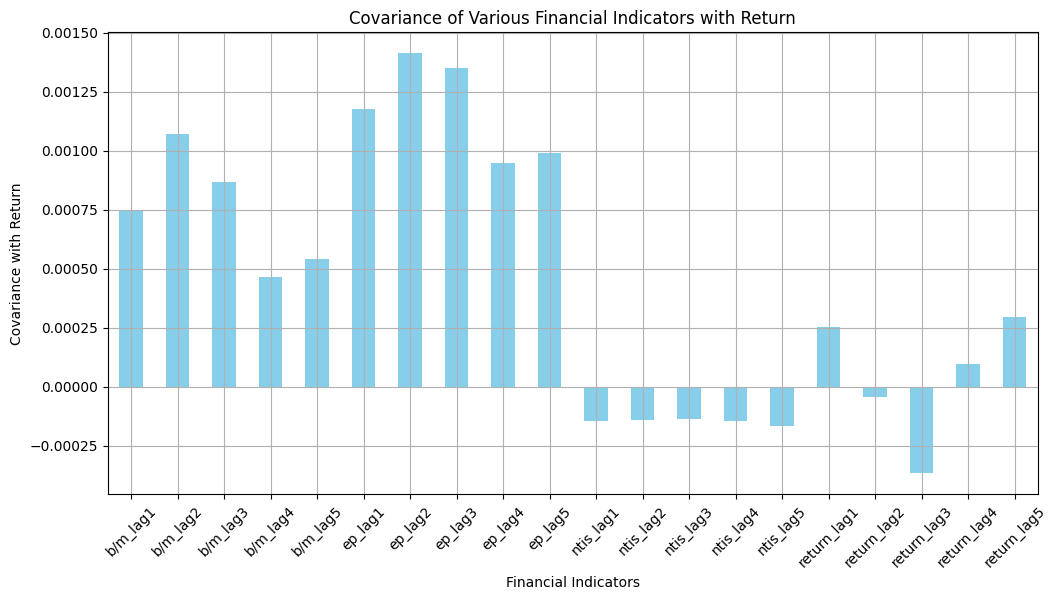

In [18]:
training["return"] = y_train
cov_matrix = training.cov()

return_covariance = cov_matrix.loc['return'].drop('return')

plt.figure(figsize=(12, 6))
return_covariance.plot(kind='bar', color='skyblue')
plt.title('Covariance of Various Financial Indicators with Return')
plt.xlabel('Financial Indicators')
plt.ylabel('Covariance with Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [19]:
lasso = Lasso()
params = {
    "alpha": np.logspace(-12,-1, 20)
}
lasso_gridsearch = GridSearchCV(lasso, params)

lasso_gridsearch.fit(X_train, y_train)
lasso_gridsearch.best_estimator_


Lasso(alpha=0.026366508987303663)

In [20]:
lasso = Lasso(alpha = 0.006952)
lasso.fit(X_train, y_train)

Lasso(alpha=0.006952)

In [21]:
X_train.columns[lasso.coef_ != 0]

Index([], dtype='object')

# Estimating Return

## Setting ARMA as Baseline

In [22]:
df['date'] = pd.to_datetime(df['date'])
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index, freq='MS') 

split = round(len(df)*0.8)  # Make sure it's data not df if df is not used afterward
return_train = data["return"][:split]  # Assuming 'return' is the column you're analyzing
return_test = data["return"][split:]

'''
def objective(trial):
    p = trial.suggest_int('p', 1, 20)
    q = trial.suggest_int('q', 1, 20)

    try:
        model = sm.tsa.arima.ARIMA(return_train, order=(p, 0, q))  # d=0 fixed as per your scenario
        result = model.fit()
    except Exception as e:
        print(e)
        return np.inf

    forecast_result = result.get_forecast(steps=len(return_test))
    forecast_mean = forecast_result.predicted_mean

    mse = mean_squared_error(return_test, forecast_mean)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"MSE: {trial.value}")
print(f"Optimal parameters: p={trial.params['p']}, q={trial.params['q']}")
'''

'\ndef objective(trial):\n    p = trial.suggest_int(\'p\', 1, 20)\n    q = trial.suggest_int(\'q\', 1, 20)\n\n    try:\n        model = sm.tsa.arima.ARIMA(return_train, order=(p, 0, q))  # d=0 fixed as per your scenario\n        result = model.fit()\n    except Exception as e:\n        print(e)\n        return np.inf\n\n    forecast_result = result.get_forecast(steps=len(return_test))\n    forecast_mean = forecast_result.predicted_mean\n\n    mse = mean_squared_error(return_test, forecast_mean)\n    return mse\n\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=100)\n\nprint("Best trial:")\ntrial = study.best_trial\nprint(f"MSE: {trial.value}")\nprint(f"Optimal parameters: p={trial.params[\'p\']}, q={trial.params[\'q\']}")\n'

In [23]:
order = (7, 0, 7)
model = sm.tsa.arima.ARIMA(return_train, order=order)
arma_result = model.fit()

n_forecast_steps = len(return_test)

forecast_result = arma_result.get_forecast(steps=n_forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

print(f"Baseline Error: {mean_squared_error(forecast_mean, return_test)}")

Baseline Error: 0.0016982463533354922


In [24]:
trace_true = go.Scatter(
    x = return_test.index,
    y = return_test,
    mode = 'lines',
    name = 'True'
)

trace_pred = go.Scatter(
    x = return_test.index,
    y = forecast_result.predicted_mean,
    mode = 'lines',
    name = 'Predicted'
)

fig = go.Figure(data=[trace_true, trace_pred])

fig.update_layout(
    title='True vs Predicted Values',
    xaxis_title='Year',
    yaxis_title='Index',
    legend_title='Legend',
    width=1000,
    height=600  
)

fig.show()

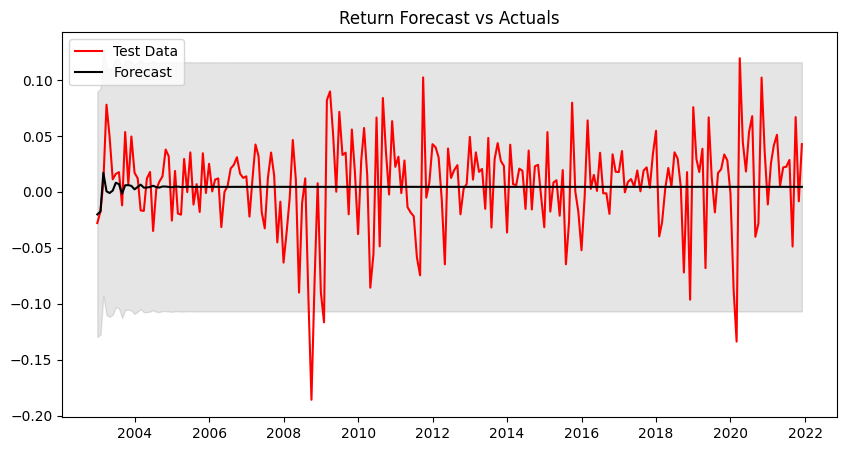

In [25]:
plt.figure(figsize=(10, 5))

plt.plot(return_test.index, return_test, label='Test Data', color='r')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='k')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)

plt.title('Return Forecast vs Actuals')
plt.legend()
plt.show()

# Gaussian Process

These numbers represent hyperparameters and settings for Gaussian process (GP) regression using scikit-learn in Python:

- l: Length scale parameter for the squared exponential (SE) kernel. It controls the smoothness of the GP function. In this case, l = 0.003.
- C(1.5, (1e-3, 1e3)): Constant kernel with a constant value of 1.5 and bounds for optimization between 1e-3 and 1e3. This kernel adds a constant value to the diagonal of the kernel matrix, improving numerical stability.
- RBF(l, (1e-2, 1e2)): Radial basis function (RBF) kernel with a length scale of l and bounds for optimization between 1e-2 and 1e2. The RBF kernel, also known as the squared exponential kernel, is commonly used for modeling stationary processes.

These hyperparameters and settings are used to define the Gaussian process regressor (gaussian_process.GaussianProcessRegressor). The regressor is configured with the defined kernel (MyKer), an initial noise variance of 0.003 (alpha), normalization of the target values (normalize_y=True), 10 restarts for optimizer to find the maximum likelihood parameters (n_restarts_optimizer=10), and a random state for reproducibility (random_state=0).

In [26]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.003  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=0.003,  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.003, kernel=1.22**2 * RBF(length_scale=0.003),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

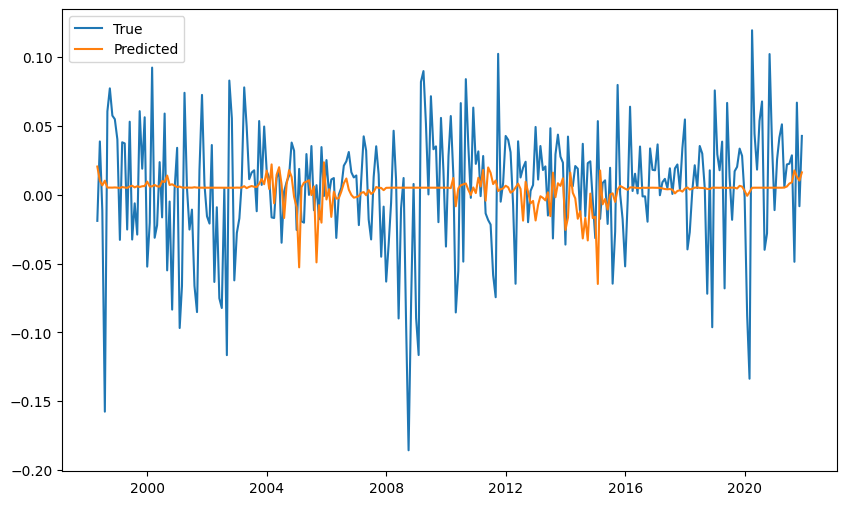

In [27]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

In [28]:
regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TRAIN --- 
 R2: 0.99998
 RMSE: 0.0
 --- TEST --- 
 R2: -0.06984
 RMSE: 0.002124
 Gap RMSE: 0.002124


# How do we find the best parameters of the Gaussian Process? 
=> Optuna

In [29]:
# Create validation to evaluate performance
T = len(training)
p = 0.75
validindex = round(p*T)

# process class sets as data frames
training_ = training.iloc[:validindex, :]
valid_ = training.iloc[validindex:, :]

X_train_, y_train_ = training_[new_features], training_[TARGET]
X_valid, y_valid = valid_[new_features], valid_[TARGET]

In [30]:
"""import optuna

# Define the objective function
def objective(trial):
    # Define hyperparameters to be optimized
    l = trial.suggest_loguniform('l', 1e-3, 1e1)
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    C_value = trial.suggest_float('C_value', 0.5, 3)
    
    # Define the kernel
    MyKer = C(C_value, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

    # Define the Gaussian Process Regressor with optimized hyperparameters
    gpfit = gaussian_process.GaussianProcessRegressor(
        kernel=MyKer,
        alpha=alpha,
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=0,
    )

    # Fit the GP regressor
    gpfit.fit(X_train_, y_train_)

    # Predict on the validation set
    y_pred = gpfit.predict(X_valid)

    # Calculate the mean squared error
    score = mean_squared_error(y_valid, y_pred)
    #score = r2_score(y_valid, y_pred)

    return score

# Define X_val and y_val for validation
# You need to define X_train and y_train as well

# Define study and optimize the objective function
study = optuna.create_study(direction='minimize') # 'maximize' for R2 | 'minimize' for RMSE
study.optimize(objective, n_trials=60)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)"""

'import optuna\n\n# Define the objective function\ndef objective(trial):\n    # Define hyperparameters to be optimized\n    l = trial.suggest_loguniform(\'l\', 1e-3, 1e1)\n    alpha = trial.suggest_float(\'alpha\', 1e-4, 1e-1, log=True)\n    C_value = trial.suggest_float(\'C_value\', 0.5, 3)\n    \n    # Define the kernel\n    MyKer = C(C_value, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))\n\n    # Define the Gaussian Process Regressor with optimized hyperparameters\n    gpfit = gaussian_process.GaussianProcessRegressor(\n        kernel=MyKer,\n        alpha=alpha,\n        normalize_y=True,\n        n_restarts_optimizer=10,\n        random_state=0,\n    )\n\n    # Fit the GP regressor\n    gpfit.fit(X_train_, y_train_)\n\n    # Predict on the validation set\n    y_pred = gpfit.predict(X_valid)\n\n    # Calculate the mean squared error\n    score = mean_squared_error(y_valid, y_pred)\n    #score = r2_score(y_valid, y_pred)\n\n    return score\n\n# Define X_val and y_val for validation\n# You nee

In [31]:
"""fig = optuna.visualization.plot_optimization_history(study, target_name='Validation CRPS')
fig.update_layout(autosize=True, width=800, height=500)
fig.show()"""

"fig = optuna.visualization.plot_optimization_history(study, target_name='Validation CRPS')\nfig.update_layout(autosize=True, width=800, height=500)\nfig.show()"

In [32]:
"""fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(autosize=True, width=800, height=400)
fig.show()"""

'fig = optuna.visualization.plot_param_importances(study)\nfig.update_layout(autosize=True, width=800, height=400)\nfig.show()'

In [33]:
"""params = study.best_params

MyKer = C(params['C_value'], (1e-3, 1e3)) * RBF(params['l'], (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=params['alpha'],  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)"""

"params = study.best_params\n\nMyKer = C(params['C_value'], (1e-3, 1e3)) * RBF(params['l'], (1e-2, 1e2))\n\n# Define the Gaussian Process Regressor\ngpfit = gaussian_process.GaussianProcessRegressor(\n    kernel=MyKer,\n    alpha=params['alpha'],  # the initial noise variance: 0.001 default min value\n    normalize_y=True,\n    n_restarts_optimizer=10,\n    random_state=0,\n)\n\ngpfit.fit(X_train, y_train)"

In [34]:
regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TRAIN --- 
 R2: 0.99998
 RMSE: 0.0
 --- TEST --- 
 R2: -0.06984
 RMSE: 0.002124
 Gap RMSE: 0.002124


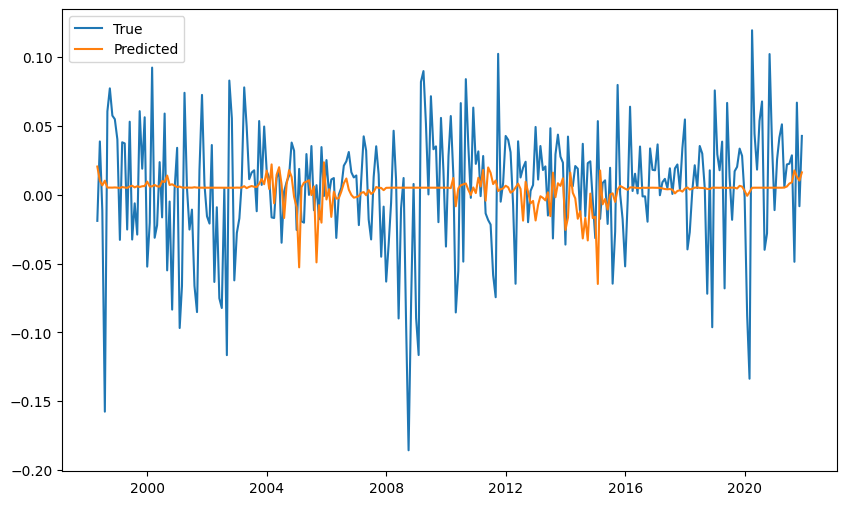

In [35]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

# Neural Network

In [36]:
set_seed(1234)

In [37]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(20, 40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc3 = nn.Linear(40, 40) 
        self.fc4 = nn.Linear(40, 1)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x) 
        return x

model = FCN()

In [38]:
#inputs = torch.from_numpy(X_train_scaled).float()
#targets = torch.from_numpy(np.array(y_train)).float()

inputs = torch.from_numpy(np.array(X_train)).float()
targets = torch.from_numpy(np.array(y_train)).float()

In [39]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 500

tolerance = 1e-6
last_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(inputs.size(0)):
        
        outputs = model(inputs[i].unsqueeze(0))

        loss = criterion(outputs, targets[i].unsqueeze(0)) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    average_loss = total_loss/inputs.size(0)
        
    if abs(last_loss - average_loss) < tolerance:
        print(f"Stopping early at epoch {epoch+1}")
        break

    last_loss = average_loss

    average_loss = total_loss / inputs.size(0)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    scheduler.step()

Epoch [10/500], Average Loss: 0.0026
Epoch [20/500], Average Loss: 0.0024
Epoch [30/500], Average Loss: 0.0023
Epoch [40/500], Average Loss: 0.0023
Stopping early at epoch 45


In [40]:
test_tensor = torch.from_numpy(np.array(X_test)).float()
insample_predict = model(inputs).detach().numpy()
outsample_predict = model(test_tensor).detach().numpy()

regression_metrics(y_train, insample_predict, 
                   y_test, outsample_predict) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': outsample_predict.flatten()})

# Plot the results
trace_true = go.Scatter(
    x = df_res.index,
    y = df_res['true'],
    mode = 'lines',
    name = 'True'
)

trace_pred = go.Scatter(
    x = df_res.index,
    y = df_res['pred'],
    mode = 'lines',
    name = 'Predicted'
)

fig = go.Figure(data=[trace_true, trace_pred])

fig.update_layout(
    title='True vs Predicted Values',
    xaxis_title='Year',
    yaxis_title='Index',
    legend_title='Legend',
    width=1000,
    height=600  
)

# Show the figure
fig.show()

 --- TRAIN --- 
 R2: 0.29679
 RMSE: 0.002275
 --- TEST --- 
 R2: -0.5593
 RMSE: 0.003095
 Gap RMSE: 0.00082


 --- TRAIN --- 
 R2: 0.10938
 RMSE: 0.002882
 --- TEST --- 
 R2: -4.45406
 RMSE: 0.010826
 Gap RMSE: 0.007944


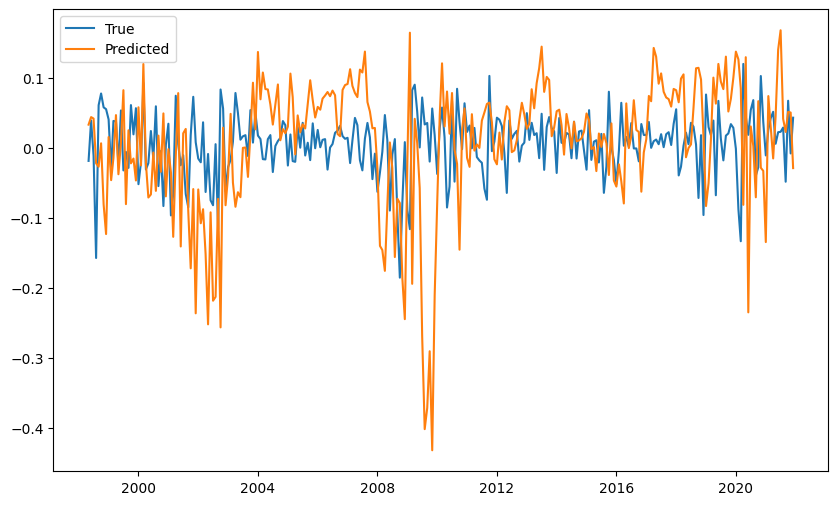

In [41]:
size = 40
mlp1 = MLPRegressor(
    hidden_layer_sizes = (size, size, size),
    max_iter=100000,
    activation="relu", #"logistic", # "tanh", "relu"
    solver="adam" # "lbfgs", "sgd"
)

mlp1.fit(X_train, y_train)

regression_metrics(y_train, mlp1.predict(X_train), 
                   y_test, mlp1.predict(X_test)) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': mlp1.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

 --- TRAIN --- 
 R2: 0.33956
 RMSE: 0.002137
 --- TEST --- 
 R2: -0.81992
 RMSE: 0.003613
 Gap RMSE: 0.0014759999999999999


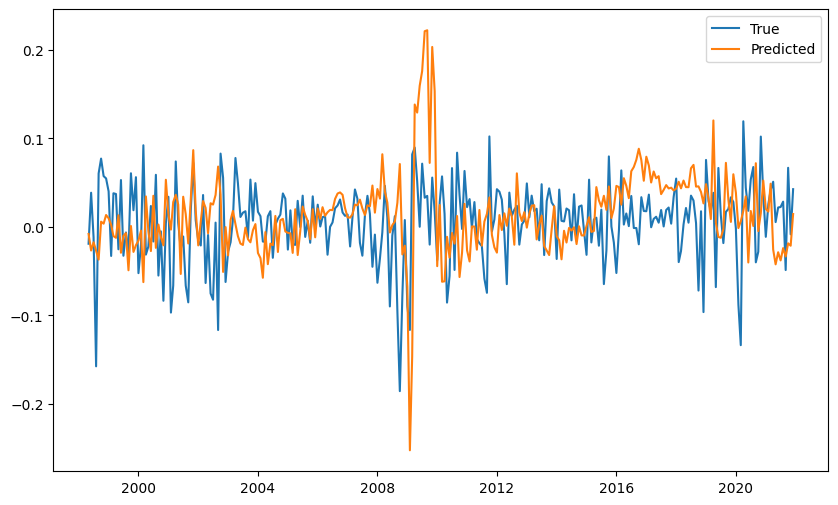

In [42]:
# Alternative using nnet with one hidden layer with size many nodes + skip layer
# Parameters to tune: size, weight decay (a regularization of tyoe L2 in penalty funct that shrinks weights)
size = 500
decay = 10 ** -2
mlp2 = MLPRegressor(
    hidden_layer_sizes=(size,), 
    max_iter=10000, 
    alpha=decay
)

mlp2.fit(X_train, y_train)

regression_metrics(y_train, mlp2.predict(X_train), 
                   y_test, mlp2.predict(X_test)) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': mlp2.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

## Estimating Price

In [63]:
TARGET = "Index"
lags = 5 #Set lags

data = df.set_index('date')[features+[TARGET]]
print(features)

data = lag_features(data, features = features + [TARGET], lags=5)
    

data = data.dropna()
data = data.drop(features, axis = 1)

new_features = list(set(data.columns).difference([TARGET]))

print(new_features)
data.head()

['b/m', 'ep', 'ntis']
['ep_lag1', 'ep_lag2', 'ep_lag5', 'ntis_lag5', 'ntis_lag4', 'b/m_lag4', 'b/m_lag3', 'ntis_lag3', 'ntis_lag1', 'b/m_lag1', 'Index_lag4', 'Index_lag2', 'Index_lag1', 'ep_lag4', 'ntis_lag2', 'Index_lag5', 'b/m_lag2', 'ep_lag3', 'b/m_lag5', 'Index_lag3']


,Index,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,Index_lag1,Index_lag2,Index_lag3,Index_lag4,Index_lag5
date,,,,,,,,,,,,,,,,,,,,,
1927-06-01,14.77,0.434783,0.456754,0.469765,0.428501,0.443706,-2.531446,-2.471309,-2.445079,-2.430353,...,0.055275,0.050514,0.046357,0.051668,0.050824,14.91,14.17,13.93,13.84,13.21
1927-07-01,15.73,0.452385,0.434783,0.456754,0.469765,0.428501,-2.531330,-2.531446,-2.471309,-2.445079,...,0.058822,0.055275,0.050514,0.046357,0.051668,14.77,14.91,14.17,13.93,13.84
1927-08-01,16.43,0.414553,0.452385,0.434783,0.456754,0.469765,-2.603707,-2.531330,-2.531446,-2.471309,...,0.059750,0.058822,0.055275,0.050514,0.046357,15.73,14.77,14.91,14.17,13.93
1927-09-01,17.14,0.396227,0.414553,0.452385,0.434783,0.456754,-2.656742,-2.603707,-2.531330,-2.531446,...,0.054522,0.059750,0.058822,0.055275,0.050514,16.43,15.73,14.77,14.91,14.17
1927-10-01,16.23,0.380586,0.396227,0.414553,0.452385,0.434783,-2.707759,-2.656742,-2.603707,-2.531330,...,0.094613,0.054522,0.059750,0.058822,0.055275,17.14,16.43,15.73,14.77,14.91


In [64]:
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

,Index,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,Index_lag1,Index_lag2,Index_lag3,Index_lag4,Index_lag5
date,,,,,,,,,,,,,,,,,,,,,
1997-12-01,970.43,0.180746,0.190001,0.177968,0.185505,0.171965,-3.172583,-3.121331,-3.148842,-3.097791,...,0.015667,0.016263,0.014634,0.012877,0.011593,955.40,914.62,947.28,899.47,954.29
1998-01-01,980.28,0.178801,0.180746,0.190001,0.177968,0.185505,-3.195884,-3.172583,-3.121331,-3.148842,...,0.015559,0.015667,0.016263,0.014634,0.012877,970.43,955.40,914.62,947.28,899.47
1998-02-01,1049.34,0.178840,0.178801,0.180746,0.190001,0.177968,-3.207495,-3.195884,-3.172583,-3.121331,...,0.013740,0.015559,0.015667,0.016263,0.014634,980.28,970.43,955.40,914.62,947.28
1998-03-01,1101.75,0.165463,0.178840,0.178801,0.180746,0.190001,-3.277088,-3.207495,-3.195884,-3.172583,...,0.012056,0.013740,0.015559,0.015667,0.016263,1049.34,980.28,970.43,955.40,914.62
1998-04-01,1111.75,0.181140,0.165463,0.178840,0.178801,0.180746,-3.327342,-3.277088,-3.207495,-3.195884,...,0.016489,0.012056,0.013740,0.015559,0.015667,1101.75,1049.34,980.28,970.43,955.40


,Index,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,Index_lag1,Index_lag2,Index_lag3,Index_lag4,Index_lag5
date,,,,,,,,,,,,,,,,,,,,,
1998-05-01,1090.82,0.175873,0.181140,0.165463,0.178840,0.178801,-3.341195,-3.327342,-3.277088,-3.207495,...,0.016405,0.016489,0.012056,0.013740,0.015559,1111.75,1101.75,1049.34,980.28,970.43
1998-06-01,1133.84,0.179102,0.175873,0.181140,0.165463,0.178840,-3.327029,-3.341195,-3.327342,-3.277088,...,0.019075,0.016405,0.016489,0.012056,0.013740,1090.82,1111.75,1101.75,1049.34,980.28
1998-07-01,1120.67,0.178061,0.179102,0.175873,0.181140,0.165463,-3.370573,-3.327029,-3.341195,-3.327342,...,0.024011,0.019075,0.016405,0.016489,0.012056,1133.84,1090.82,1111.75,1101.75,1049.34
1998-08-01,957.28,0.179438,0.178061,0.179102,0.175873,0.181140,-3.366445,-3.370573,-3.327029,-3.341195,...,0.025354,0.024011,0.019075,0.016405,0.016489,1120.67,1133.84,1090.82,1111.75,1101.75
1998-09-01,1017.01,0.211432,0.179438,0.178061,0.179102,0.175873,-3.216473,-3.366445,-3.370573,-3.327029,...,0.028519,0.025354,0.024011,0.019075,0.016405,957.28,1120.67,1133.84,1090.82,1111.75


In [65]:
scaler = StandardScaler()
columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)



### Baseline LASSO

In [69]:
lasso = Lasso()
params = {
    "alpha": np.logspace(-12,-1, 20)
}
lasso_gridsearch = GridSearchCV(lasso, params)

lasso_gridsearch.fit(X_train, y_train)
lasso_gridsearch.best_estimator_


Lasso(alpha=0.1)

In [70]:
lasso = Lasso(alpha = 0.006952)
lasso.fit(X_train, y_train)

Lasso(alpha=0.006952)

In [73]:
X_train.columns[lasso.coef_ != 0]

Index(['ep_lag1', 'ep_lag2', 'ep_lag5', 'ntis_lag5', 'b/m_lag4', 'b/m_lag3',
       'ntis_lag3', 'ntis_lag1', 'b/m_lag1', 'Index_lag4', 'Index_lag2',
       'Index_lag1', 'ep_lag4', 'ntis_lag2', 'Index_lag5', 'b/m_lag2',
       'ep_lag3', 'b/m_lag5', 'Index_lag3'],
      dtype='object')

In [106]:

predictions = lasso.predict(X_test)
regression_metrics(y_train, lasso.predict(X_train), 
                   y_test, lasso.predict(X_test)) 

 --- TRAIN --- 
 R2: 0.99739
 RMSE: 9.128162739565942
 --- TEST --- 
 R2: 0.98898
 RMSE: 88.30715607469193
 Gap RMSE: 79.178993335126


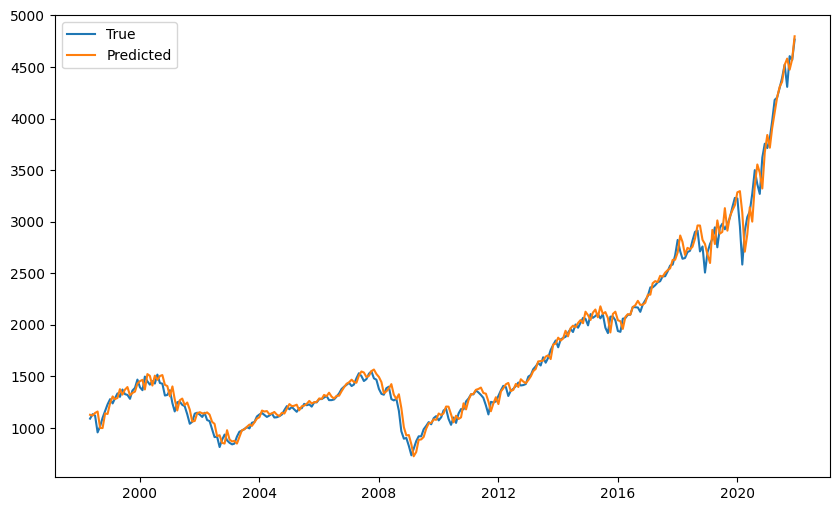

In [89]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': lasso.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()


### Gaussian Process

In [66]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.003  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=0.003,  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.003, kernel=1.22**2 * RBF(length_scale=0.003),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

In [105]:

regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TRAIN --- 
 R2: 0.99823
 RMSE: 7.51499321356979
 --- TEST --- 
 R2: 0.94869
 RMSE: 190.51608977459097
 Gap RMSE: 183.00109656102117


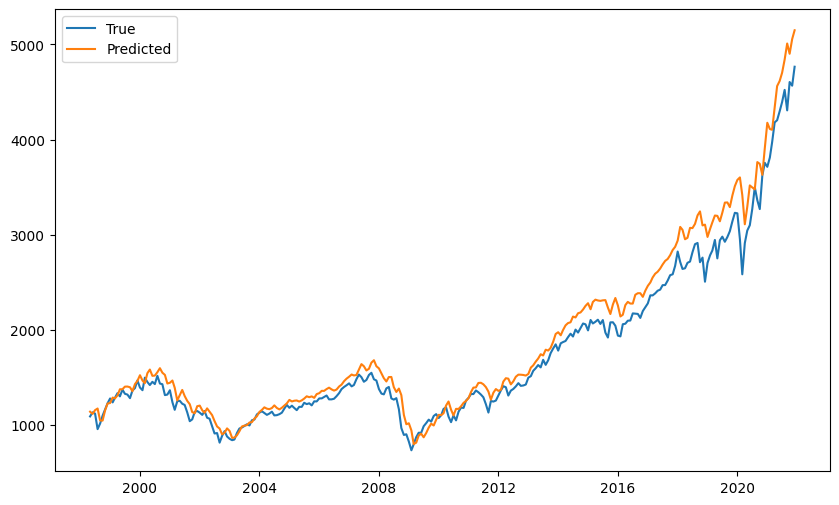

In [68]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()


### NNet

In [98]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(20, 40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc3 = nn.Linear(40, 40) 
        self.fc4 = nn.Linear(40, 1)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x) 
        return x

model = FCN()

In [99]:
#inputs = torch.from_numpy(X_train_scaled).float()
#targets = torch.from_numpy(np.array(y_train)).float()

inputs = torch.from_numpy(np.array(X_train)).float()
targets = torch.from_numpy(np.array(y_train)).float()

In [100]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 500

tolerance = 1e-6
last_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(inputs.size(0)):
        
        outputs = model(inputs[i].unsqueeze(0))

        loss = criterion(outputs, targets[i].unsqueeze(0)) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    average_loss = total_loss/inputs.size(0)
        
    if abs(last_loss - average_loss) < tolerance:
        print(f"Stopping early at epoch {epoch+1}")
        break

    last_loss = average_loss

    average_loss = total_loss / inputs.size(0)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    scheduler.step()

Epoch [10/500], Average Loss: 1690.1834
Epoch [20/500], Average Loss: 930.2433
Epoch [30/500], Average Loss: 832.6413
Epoch [40/500], Average Loss: 801.8368
Epoch [50/500], Average Loss: 791.3413
Epoch [60/500], Average Loss: 787.7183
Epoch [70/500], Average Loss: 786.4556
Epoch [80/500], Average Loss: 786.0156
Epoch [90/500], Average Loss: 785.8725
Epoch [100/500], Average Loss: 785.8348
Epoch [110/500], Average Loss: 785.8271
Epoch [120/500], Average Loss: 785.8262
Epoch [130/500], Average Loss: 785.8261
Stopping early at epoch 134


In [104]:
test_tensor = torch.from_numpy(np.array(X_test)).float()
insample_predict = model(inputs).detach().numpy()
outsample_predict = model(test_tensor).detach().numpy()

regression_metrics(y_train, insample_predict, 
                   y_test, outsample_predict) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': outsample_predict.flatten()})

# Plot the results
trace_true = go.Scatter(
    x = df_res.index,
    y = df_res['true'],
    mode = 'lines',
    name = 'True'
)

trace_pred = go.Scatter(
    x = df_res.index,
    y = df_res['pred'],
    mode = 'lines',
    name = 'Predicted'
)

fig = go.Figure(data=[trace_true, trace_pred])

fig.update_layout(
    title='True vs Predicted Values',
    xaxis_title='Year',
    yaxis_title='Index',
    legend_title='Legend',
    width=1000,
    height=600  
)

# Show the figure
fig.show()

 --- TRAIN --- 
 R2: 0.97538
 RMSE: 28.03258921327104
 --- TEST --- 
 R2: 0.97516
 RMSE: 132.54222615076299
 Gap RMSE: 104.50963693749195


# Binary classification

In [43]:
def lag_features(df, features, lags):
    df_ = df.copy()
    
    if isinstance(lags, int):
        for feature in features:
            for lag in range(1, lags + 1):
                df_[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    elif isinstance(lags, list):
        if len(features) != len(lags):
            raise ValueError("Length of 'features' and 'lags' must match when 'lags' is a list.")
        for feature, lag in zip(features, lags):
            for l in range(1, lag + 1):
                df_[f'{feature}_lag{l}'] = df[feature].shift(l)
    else:
        raise TypeError("Lags must be either an integer or a list of integers.")
    
    return df_

In [44]:
lags = 5
TARGET = 'direction'
data = df.set_index('date')[features+['return', TARGET]]
print(features)


data = lag_features(df = data, features=features+[TARGET], lags = 5)


data = data.dropna()
data = data.drop("return", axis = 1)
data = data.drop(features, axis = 1)

new_features = list(set(data.columns).difference(['return', TARGET]))
print(new_features)

data.head()

['b/m', 'ep', 'ntis']


['ep_lag1', 'ep_lag2', 'ep_lag5', 'ntis_lag5', 'ntis_lag4', 'direction_lag5', 'b/m_lag4', 'b/m_lag3', 'direction_lag2', 'ntis_lag3', 'ntis_lag1', 'b/m_lag1', 'ep_lag4', 'ntis_lag2', 'b/m_lag2', 'direction_lag1', 'direction_lag3', 'ep_lag3', 'b/m_lag5', 'direction_lag4']


,direction,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,direction_lag1,direction_lag2,direction_lag3,direction_lag4,direction_lag5
date,,,,,,,,,,,,,,,,,,,,,
1927-06-01,False,0.434783,0.456754,0.469765,0.428501,0.443706,-2.531446,-2.471309,-2.445079,-2.430353,...,0.055275,0.050514,0.046357,0.051668,0.050824,True,True,True,True,False
1927-07-01,True,0.452385,0.434783,0.456754,0.469765,0.428501,-2.531330,-2.531446,-2.471309,-2.445079,...,0.058822,0.055275,0.050514,0.046357,0.051668,False,True,True,True,True
1927-08-01,True,0.414553,0.452385,0.434783,0.456754,0.469765,-2.603707,-2.531330,-2.531446,-2.471309,...,0.059750,0.058822,0.055275,0.050514,0.046357,True,False,True,True,True
1927-09-01,True,0.396227,0.414553,0.452385,0.434783,0.456754,-2.656742,-2.603707,-2.531330,-2.531446,...,0.054522,0.059750,0.058822,0.055275,0.050514,True,True,False,True,True
1927-10-01,False,0.380586,0.396227,0.414553,0.452385,0.434783,-2.707759,-2.656742,-2.603707,-2.531330,...,0.094613,0.054522,0.059750,0.058822,0.055275,True,True,True,False,True


In [45]:
# Time Series Train test split
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

,direction,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,direction_lag1,direction_lag2,direction_lag3,direction_lag4,direction_lag5
date,,,,,,,,,,,,,,,,,,,,,
1997-12-01,True,0.180746,0.190001,0.177968,0.185505,0.171965,-3.172583,-3.121331,-3.148842,-3.097791,...,0.015667,0.016263,0.014634,0.012877,0.011593,True,False,True,False,True
1998-01-01,True,0.178801,0.180746,0.190001,0.177968,0.185505,-3.195884,-3.172583,-3.121331,-3.148842,...,0.015559,0.015667,0.016263,0.014634,0.012877,True,True,False,True,False
1998-02-01,True,0.178840,0.178801,0.180746,0.190001,0.177968,-3.207495,-3.195884,-3.172583,-3.121331,...,0.013740,0.015559,0.015667,0.016263,0.014634,True,True,True,False,True
1998-03-01,True,0.165463,0.178840,0.178801,0.180746,0.190001,-3.277088,-3.207495,-3.195884,-3.172583,...,0.012056,0.013740,0.015559,0.015667,0.016263,True,True,True,True,False
1998-04-01,True,0.181140,0.165463,0.178840,0.178801,0.180746,-3.327342,-3.277088,-3.207495,-3.195884,...,0.016489,0.012056,0.013740,0.015559,0.015667,True,True,True,True,True


,direction,b/m_lag1,b/m_lag2,b/m_lag3,b/m_lag4,b/m_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,direction_lag1,direction_lag2,direction_lag3,direction_lag4,direction_lag5
date,,,,,,,,,,,,,,,,,,,,,
1998-05-01,False,0.175873,0.181140,0.165463,0.178840,0.178801,-3.341195,-3.327342,-3.277088,-3.207495,...,0.016405,0.016489,0.012056,0.013740,0.015559,True,True,True,True,True
1998-06-01,True,0.179102,0.175873,0.181140,0.165463,0.178840,-3.327029,-3.341195,-3.327342,-3.277088,...,0.019075,0.016405,0.016489,0.012056,0.013740,False,True,True,True,True
1998-07-01,False,0.178061,0.179102,0.175873,0.181140,0.165463,-3.370573,-3.327029,-3.341195,-3.327342,...,0.024011,0.019075,0.016405,0.016489,0.012056,True,False,True,True,True
1998-08-01,False,0.179438,0.178061,0.179102,0.175873,0.181140,-3.366445,-3.370573,-3.327029,-3.341195,...,0.025354,0.024011,0.019075,0.016405,0.016489,False,True,False,True,True
1998-09-01,True,0.211432,0.179438,0.178061,0.179102,0.175873,-3.216473,-3.366445,-3.370573,-3.327029,...,0.028519,0.025354,0.024011,0.019075,0.016405,False,False,True,False,True


## Random Classificer Baseline

In [46]:
majority_predict = [1] * len(y_test)

In [47]:

classification_metrics(y_train, y_train, 
                    y_test, majority_predict) 

 --- TRAIN --- 
 Accuracy: 1.0
 Precision: 1.0
 Recall: 1.0
 F1-score: 1.0
 --- TEST --- 
 Accuracy: 0.62324
 Precision: 0.62324
 Recall: 1.0
 F1-score: 0.7679


# Gaussian Process

In [48]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.15  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
class_gpfit = gaussian_process.GaussianProcessClassifier(
    kernel=MyKer,
    n_restarts_optimizer=10,
    random_state=0,
)

class_gpfit.fit(X_train, y_train)

# Does Gaussian Process has predict_proba??

KeyboardInterrupt: 

In [ ]:
predictions = class_gpfit.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_test, predictions[:,1])

0.5062569301441471

In [ ]:
from joblib import dump, load

dump(class_gpfit, 'gp_classifier.joblib')
class_gpfit = load('gp_classifier.joblib')

In [ ]:
classification_metrics(y_train, class_gpfit.predict(X_train), 
                   y_test, class_gpfit.predict(X_test)) 

 --- TRAIN --- 
 Accuracy: 0.6134
 Precision: 0.61321
 Recall: 0.91549
 F1-score: 0.73446
 --- TEST --- 
 Accuracy: 0.62324
 Precision: 0.62324
 Recall: 1.0
 F1-score: 0.7679


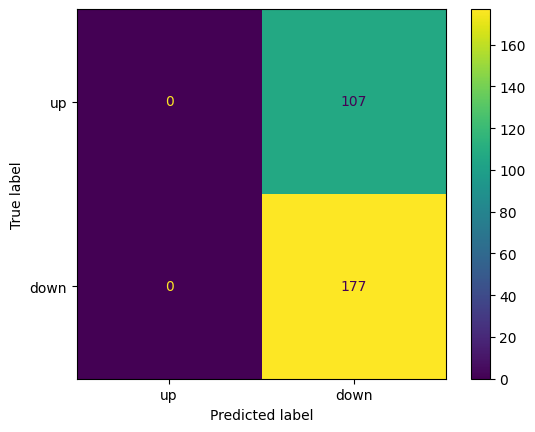

In [ ]:
cm = confusion_matrix(y_test, class_gpfit.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()

## NNet

In [ ]:
class binary_nnet(nn.Module):
    def __init__(self):
        super(binary_nnet, self).__init__()
        self.fc1 = nn.Linear(20, 40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc3 = nn.Linear(40, 40) 
        self.fc4 = nn.Linear(20, 10)
        self.fc5 = nn.Linear(40, 1)
        # Activation function
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.relu(self.fc3(x))
        #x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

model = binary_nnet()

In [ ]:
inputs = torch.from_numpy(np.array(X_train).astype(float)).float()
targets = torch.from_numpy(np.array(y_train).astype(float)).float()

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

num_epochs = 500
tolerance = 1e-4

last_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0
    
    for i in range(inputs.size(0)):
        outputs = model(inputs[i].unsqueeze(0))
        targets_float = targets[i].unsqueeze(0).float()

        targets_float = targets_float.view_as(outputs)

        loss = criterion(outputs, targets_float) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    average_loss = total_loss / inputs.size(0)
    
    if abs(last_loss - average_loss) < tolerance:
        print(f"Stopping early at epoch {epoch+1}")
        break

    last_loss = average_loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    
    scheduler.step()

Epoch [10/500], Average Loss: 0.6235
Epoch [20/500], Average Loss: 0.5248
Epoch [30/500], Average Loss: 0.4144
Epoch [40/500], Average Loss: 0.3314
Epoch [50/500], Average Loss: 0.2649
Epoch [60/500], Average Loss: 0.2062
Epoch [70/500], Average Loss: 0.1948
Epoch [80/500], Average Loss: 0.1269
Epoch [90/500], Average Loss: 0.1068
Epoch [100/500], Average Loss: 0.0854
Epoch [110/500], Average Loss: 0.0642
Epoch [120/500], Average Loss: 0.0566
Epoch [130/500], Average Loss: 0.0483
Epoch [140/500], Average Loss: 0.0409
Epoch [150/500], Average Loss: 0.0546
Stopping early at epoch 157


In [ ]:
#torch.save(model, "direction_torch.pth")
#model = torch.load("direction_torch.pth")

In [ ]:
test_tensor = torch.from_numpy(np.array(X_test).astype(float)).float()
insample_prob = model(inputs).detach().numpy()
outsample_prob = model(test_tensor).detach().numpy()

insample_predict = [1 if x> 0.5 else 0 for x in insample_prob]
outsample_predict = [1 if x> 0.5 else 0 for x in outsample_prob]

classification_metrics(y_train, insample_predict, 
                    y_test, outsample_predict) 

 --- TRAIN --- 
 Accuracy: 0.98355
 Precision: 0.98788
 Recall: 0.9839
 F1-score: 0.98589
 --- TEST --- 
 Accuracy: 0.55634
 Precision: 0.62562
 Recall: 0.71751
 F1-score: 0.66842


In [ ]:
roc_auc_score(y_test, 1-outsample_prob)

0.524209303553514

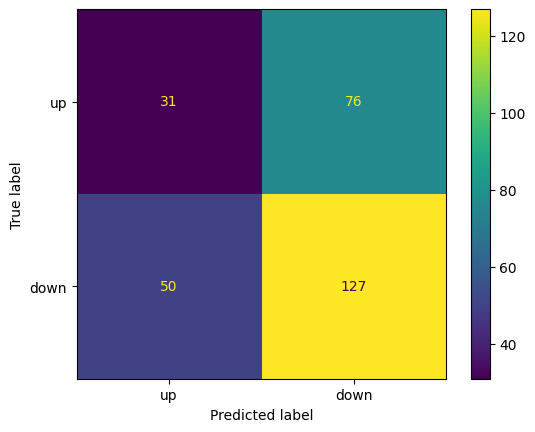

In [ ]:
cm = confusion_matrix(y_test, outsample_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()

In [ ]:
misclassifications = (outsample_predict != y_test).tolist()


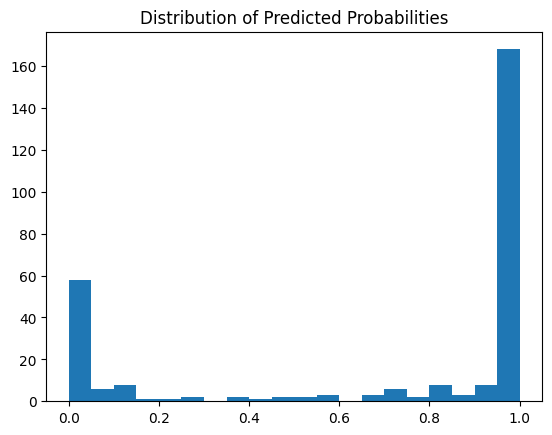

In [ ]:
plt.hist(x = outsample_prob, bins = 20)
plt.title("Distribution of Predicted Probabilities")
plt.show()

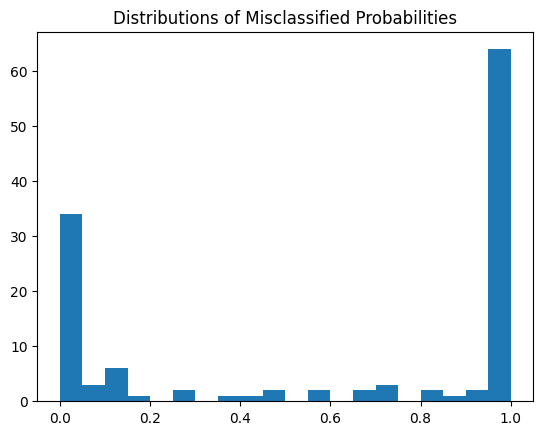

In [ ]:
plt.hist( x= pd.Series(outsample_prob.flatten())[misclassifications], bins = 20)
plt.title("Distributions of Misclassified Probabilities")
plt.show()

## Estimating Price

NameError: name 'df' is not defined